In [1]:
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchsummary import summary

from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Machine_Learning/Crack_Detection/data') #/
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection/data
Negative/  Positive/  VAOE_images/


In [4]:
# Normalization parameters for pre-trained PyTorch models
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, lr_shape):
        lr_height, lr_width = lr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((lr_height, lr_height), Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('RGB')
        img_lr = self.lr_transform(img)
        #img_lr = img_lr/255.
        return {"lr": img_lr}

    def __len__(self):
        return len(self.files)

# Configure data loader
#dir_data = pathlib.Path('data')
dataset_path = "Negative"
lr_shape=(128, 128)

train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.1)
train_loader = DataLoader(ImageDataset(train_paths, lr_shape=lr_shape), batch_size=64, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(ImageDataset(test_paths, lr_shape=lr_shape), batch_size=32, shuffle=True, num_workers=2, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


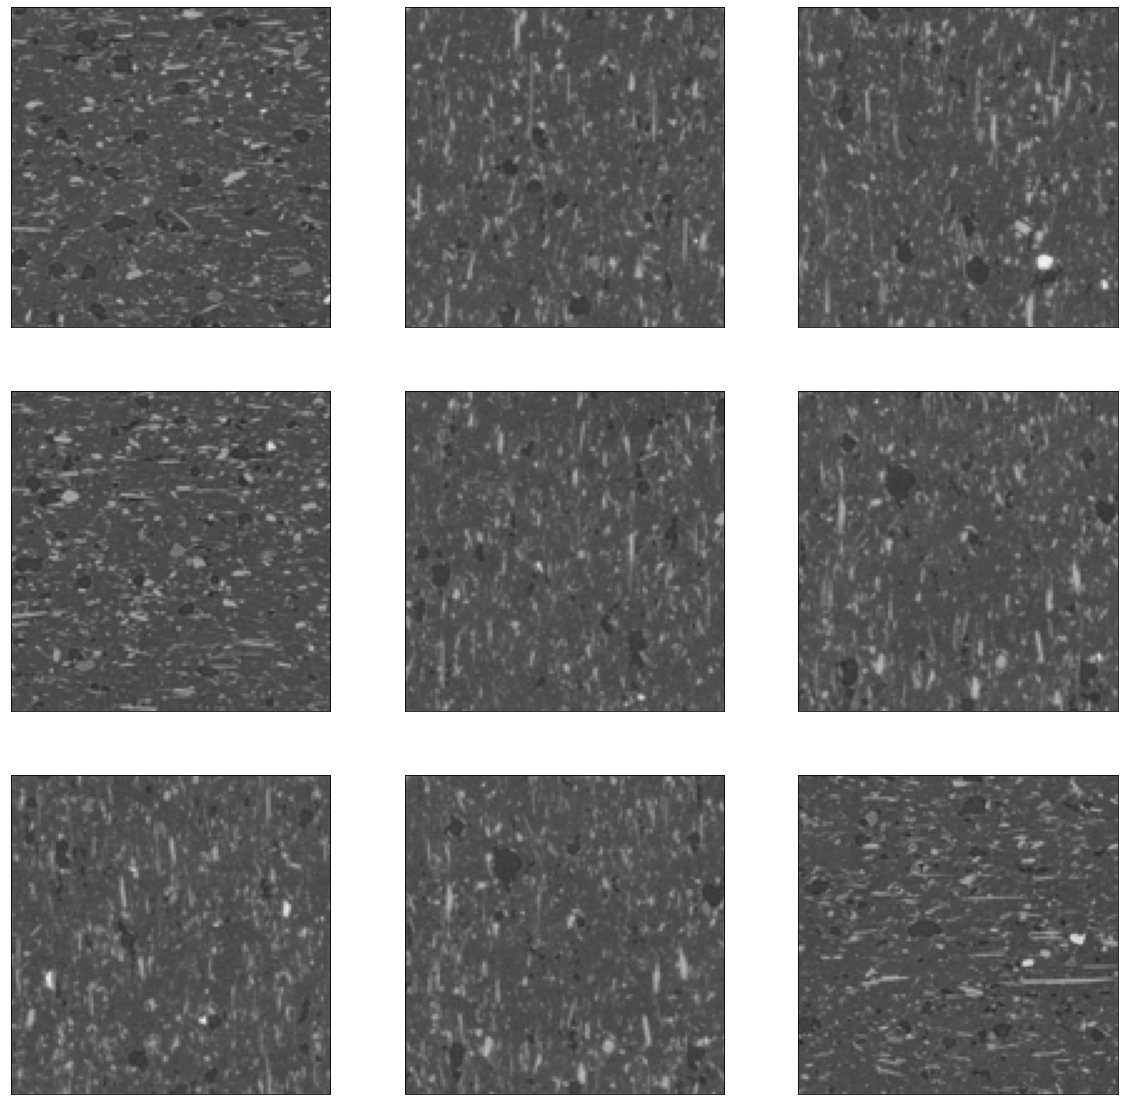

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap = "gray", vmin= np.min(img), vmax=np.max(img)) 

#Obtain one batch of training images
dataiter = iter(train_loader)
imgs = dataiter.next()
images = imgs["lr"]
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(20, 20))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
features = 32
# define a simple linear VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        #self.enc1 = nn.Linear(in_features=784*16, out_features=512*4)
        #self.enc2 = nn.Linear(in_features=512*4, out_features=features*2)
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64*2, 3, stride=1, padding=1), nn.BatchNorm2d(64*2), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64*3, 3, stride=1, padding=1), nn.BatchNorm2d(64*3), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv4 = nn.Sequential(nn.Conv2d(64*3, 64*4, 3, stride=1, padding=1), nn.BatchNorm2d(64*4), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv5 = nn.Sequential(nn.Conv2d(64*4, 64*5, 3, stride=1, padding=1), nn.BatchNorm2d(64*5), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv6 = nn.Sequential(nn.Conv2d(64*5, 64*6, 3, stride=1, padding=1), nn.BatchNorm2d(64*6), nn.ReLU(True), nn.MaxPool2d(2, 2))#
        self.conv7 = nn.Sequential(nn.Conv2d(64*6, 64*7, 3, stride=1, padding=1), nn.BatchNorm2d(64*7), nn.ReLU(True), nn.MaxPool2d(2, 2), nn.Flatten())#
        self.conv8 = nn.Sequential(nn.Linear(in_features=64*7, out_features=features))#, nn.BatchNorm2d(features*2), nn.BatchNorm2d(features*2), , nn.ReLU(True)
        #self.m = nn.BatchNorm1d(features)

        # decoder 
        #self.dec = nn.Linear(in_features=features, out_features=2*2*64*6)
        #self.dec2 = nn.Linear(in_features=512*4, out_features=784*16)      
        self.conv8_T = nn.Sequential(nn.ConvTranspose2d(features, 64*7, 3, stride=1, padding=1), nn.BatchNorm2d(64*7), nn.ReLU(True))#nn.Dropout(p=0.2),
        self.conv7_T = nn.Sequential(nn.ConvTranspose2d(64*7, 64*6, 4, stride=2, padding=1), nn.BatchNorm2d(64*6), nn.ReLU(True))#nn.Dropout(p=0.2), nn.BatchNorm2d(64*7),  nn.BatchNorm2d(64*6),
        self.conv6_T = nn.Sequential(nn.ConvTranspose2d(64*6, 64*5, 4, stride=2, padding=1), nn.BatchNorm2d(64*5), nn.ReLU(True))#nn.Dropout(p=0.2), nn.BatchNorm2d(64*5),
        self.conv5_T = nn.Sequential(nn.ConvTranspose2d(64*5, 64*4, 4, stride=2, padding=1), nn.BatchNorm2d(64*4), nn.ReLU(True))#nn.Dropout(p=0.2), nn.BatchNorm2d(64*4),
        self.conv4_T = nn.Sequential(nn.ConvTranspose2d(64*4, 64*3, 4, stride=2, padding=1), nn.BatchNorm2d(64*3), nn.ReLU(True))# nn.Dropout(p=0.2), nn.BatchNorm2d(64*3),
        self.conv3_T = nn.Sequential(nn.ConvTranspose2d(64*3, 64*2, 4, stride=2, padding=1), nn.BatchNorm2d(64*2), nn.ReLU(True))#nn.Dropout(p=0.2), nn.BatchNorm2d(64*2),
        self.conv2_T = nn.Sequential(nn.ConvTranspose2d(64*2, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))#nn.Dropout(p=0.2), nn.BatchNorm2d(64), 
        self.conv1_T = nn.Sequential(nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)) #, nn.Sigmoid() #, nn.ReLU(True)
      
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def encoder(self, x):
        # encoding
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        mu = self.conv8(x)
        log_var = self.conv8(x)
        
        #x = self.conv8(x).view(-1, 2, features)
        # get `mu` and `log_var`
        #mu = x[:, 0, :] # the first feature values as mean
        #log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        return mu, log_var
        
    def decoder(self, z):    
        # decoding
        #x = F.relu(self.dec(z))
        x = self.conv8_T(z.view(-1, features, 1, 1))
        x = self.conv7_T(x)
        x = self.conv6_T(x)
        x = self.conv5_T(x)
        x = self.conv4_T(x)
        x = self.conv3_T(x)
        x = self.conv2_T(x)       
        reconstruction = self.conv1_T(x)#torch.sigmoid(self.conv1_T(x))
        return reconstruction
    
    def forward (self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)#self.reparameterize(self.m(mu), log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

In [7]:
# leanring parameters
epochs = 0
batch_size = 64
lr = 0.00005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = VAE().to(device)#model.
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss() #nn.BCELoss()#reduction='sum'

load_pretrained_models = True
model_path = "Var_AEC/model.pth"
if load_pretrained_models:
    %cd ..
    model.load_state_dict(torch.load(model_path,map_location=device))
    %cd data

from torchsummary import summary
summary(model, (3,128,128))

/content/drive/My Drive/Machine_Learning/Crack_Detection
/content/drive/My Drive/Machine_Learning/Crack_Detection/data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 192, 32, 32]         221,376
      BatchNorm2d-10          [-1, 192, 32, 32]             384
             ReLU-11          [-1, 192, 32, 32]               0
        MaxPool2d-12          [-1, 192, 16, 16] 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
def final_loss(out, bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    #We will scale the following losses with this factor
    scaling_factor = out.shape[0]*out.shape[1]*out.shape[2]*out.shape[3]   
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= scaling_factor
    return BCE + KLD

In [10]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for imgs in dataloader:#tqdm(enumerate(dataloader), total=int(len(dataloader)):
        data = imgs["lr"] 
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(reconstruction, bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [11]:
#valid_images = test_images_T
size = 128
batch_size=32
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs in dataloader:
            data = imgs["lr"]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(reconstruction, bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if epoch % 30 == 0:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 3, size, size)[:8], 
                                  reconstruction.view(batch_size, 3, size, size)[:8]))
                save_image(both.cpu(), f"VAOE_images/{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [12]:
train_loss = []
#val_loss = []
for epoch in range(epochs):
    #
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    #val_loss.append(val_epoch_loss)
    if epoch % 10 == 0:
        print(f"\nEpoch {epoch+1} of {epochs}")
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")
    # Save model checkpoints
    if (epoch+1)%100 == 0:
        %cd ..
        torch.save(model.state_dict(), "Var_AEC/model.pth")
        print("save model!")    
        %cd data

Reconstructed Images


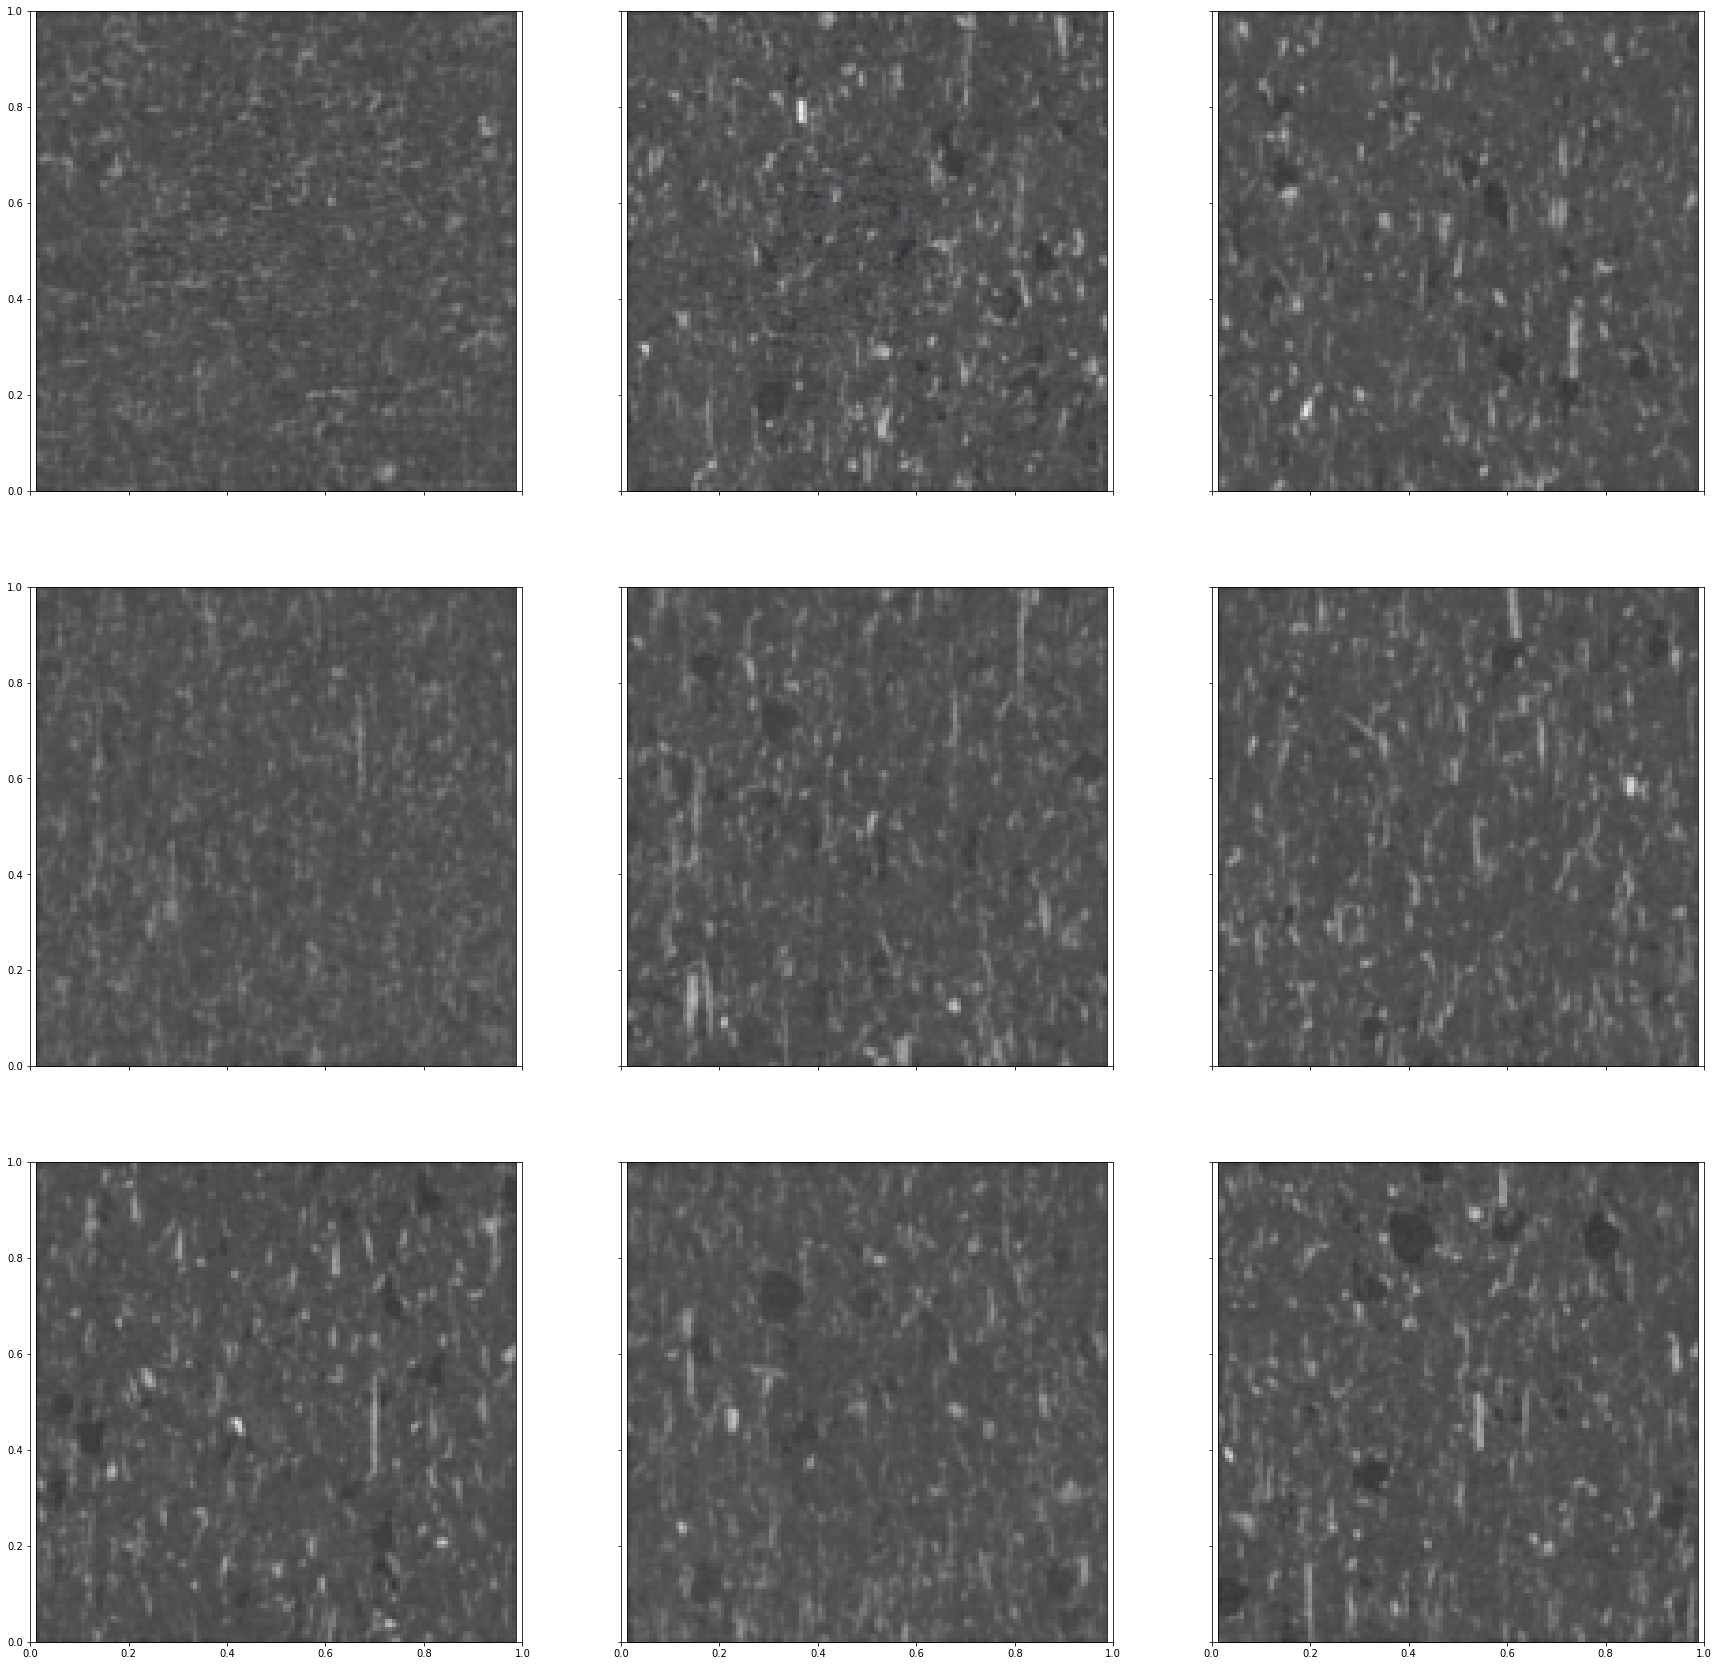

In [13]:
rand_z = torch.randn(batch_size, features)
out = model.decoder(rand_z.to(device))

output = out.cpu()
output = output.view(batch_size, 3, 128, 128)
output = output.detach().numpy()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(30,30))
for idx_1 in np.arange(3):
  for idx_2 in np.arange(3):
    ax = fig.add_subplot(3, 3, (idx_1)*3 + idx_2+1, xticks=[], yticks=[])
    imshow(output[(idx_1)*3 + idx_2])
plt.show() 